In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex
from osd.utilities import progress
import cvxpy as cvx
SOLVER = 'OSQP'

# Convex example, $K=3$

In [3]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

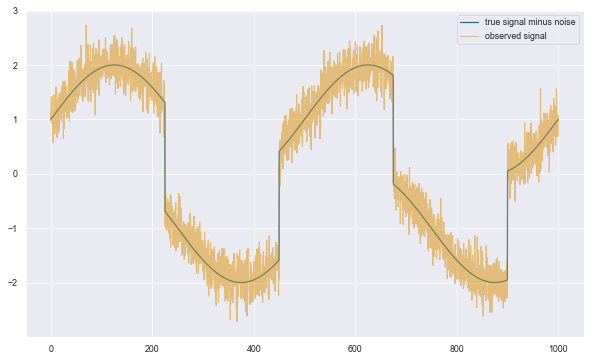

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# Solve problem all at once with CVXPY

In [5]:
problem = Problem(data=y, components=[GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex(vavg=0)])
problem.weights.value = [1., 1e7, 1e1]
problem.decompose(solver=SOLVER)
problem.problem.value

255.7447842492718

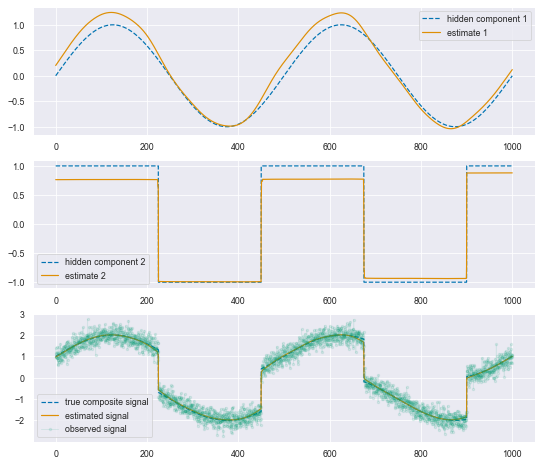

In [6]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Simple implementation of ADMM algorithm

Nothing fancy here. Just a quick and dirty implementation of the three proximal operators.

In [7]:
def prox1(v, theta, rho):
    r = rho / (2 * theta + rho)
    return r * v

def prox2(v, theta, rho, A=None, return_A=True):
    if A is None:
        n = len(v)
        M = np.diff(np.eye(n), axis=0, n=2)
        r = 2 * theta / rho
        A = np.linalg.inv(np.eye(n) + r * M.T.dot(M))
    if not return_A:
        return A.dot(v)
    else:
        return A.dot(v), A

def prox3_cvx(v, theta, rho):
    n = len(v)
    M = np.diff(np.eye(n), axis=0, n=1)
    x = cvx.Variable(n)
    cost = theta * cvx.norm1(cvx.diff(x)) + (rho / 2) * cvx.sum_squares(x - v)
    problem = cvx.Problem(cvx.Minimize(cost), [cvx.sum(x) == 0])
    problem.solve()
    return x.value

def calc_obj(x1, x2, x3, rho1=1, rho2=1e7, rho3=1e1):
    t1 = rho1 * np.sum(np.power(x1, 2))
    t2 = rho2 * np.sum(np.power(np.diff(x2, 2), 2))
    t3 = rho3 * np.sum(np.abs(np.diff(x3, 1)))
    return t1 + t2 + t3

def run_admm(data, num_iter=50, rho=0.5, verbose=True, prox3=prox3_cvx):
    y = data
    A = None
    u = np.zeros_like(y)
    x1 = y / 3
    x2 = y / 3
    x3 = y / 3
    residuals = []
    obj_vals = []
    ti = time()
    for it in range(num_iter):
        if verbose:
            td = time() - ti
            progress(it, num_iter, '{:.2f} sec'.format(td))
        x1 = prox1(x1 - u, 1, rho)
        x2, A = prox2(x2 - u, 1e7, rho, A=A, return_A=True)
        x3 = prox3(x3 - u, 1e1, rho)
        u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
        residuals.append(np.linalg.norm(np.average([x1, x2, x3], axis=0) - y / 3))
        obj_vals.append(calc_obj(x1, x2, x3))
    if verbose:
        td = time() - ti
        progress(it + 1, num_iter, '{:.2f} sec\n'.format(td))
    outdict = {
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'u': u,
        'residuals': residuals,
        'obj_vals': obj_vals
    }
    return outdict

In [8]:
run1 = run_admm(y, num_iter=50, rho=1e-1)
run2 = run_admm(y, num_iter=50, rho=1e0)
run3 = run_admm(y, num_iter=50, rho=1e1)

[============================================================] 100.0% ...51.45 sec
[============================================================] 100.0% ...68.57 sec
[============================================================] 100.0% ...85.39 sec


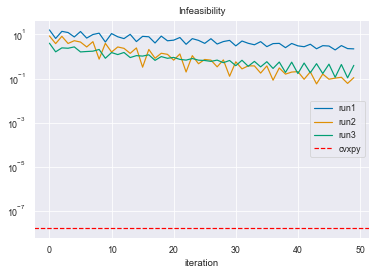

In [9]:
r = np.linalg.norm(
    np.average(problem.estimates, axis=0) - y / 3
)
plt.plot(run1['residuals'], label='run1')
plt.plot(run2['residuals'], label='run2')
plt.plot(run3['residuals'], label='run3')
plt.axhline(r, ls='--', color='red', label='cvxpy')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

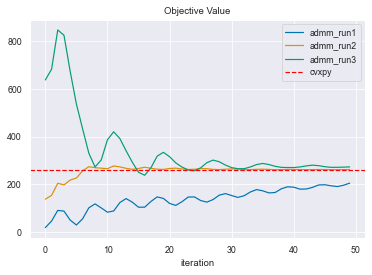

In [10]:
plt.plot(run1['obj_vals'], label='admm_run1')
plt.plot(run2['obj_vals'], label='admm_run2')
plt.plot(run3['obj_vals'], label='admm_run3')
plt.axhline(problem.problem.objective.value, ls='--', color='red', label='cvxpy')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration');

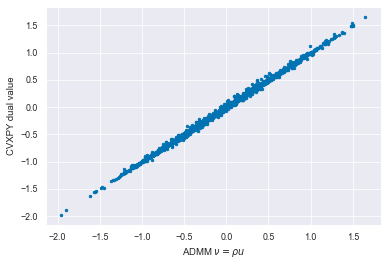

In [11]:
plt.plot(1e0 * run2['u'], problem.problem.constraints[-1].dual_value, ls='none', marker='.')
plt.xlabel('ADMM $\\nu = \\rho u$')
plt.ylabel('CVXPY dual value');

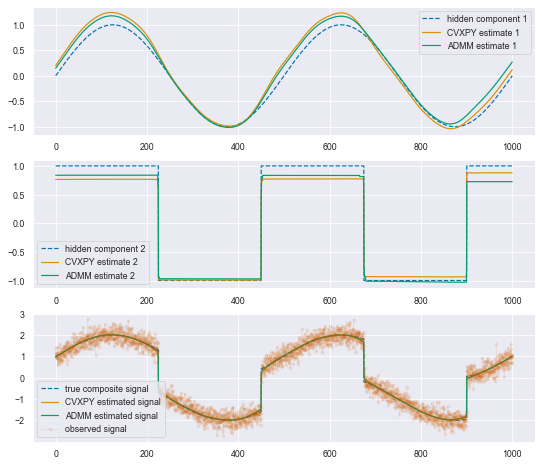

In [12]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run2['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run2['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run2['x2'] + run2['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Non-convex model

Replace the heuristic for a sparse first difference with the constraint that $x^3\in\left\{-1,1\right\}^T$. Objective function is calculated using the L1-heuristic to allow for an apples-to-apples comparison to previous results.

In [13]:
def prox3_noncvx(v, theta, rho):
    v1 = np.ones_like(v)
    v2 = -1 * np.ones_like(v)
    d1 = np.abs(v - v1)
    d2 = np.abs(v - v2)
    x = np.ones_like(v1)
    x[d2 < d1] = -1
    return x

In [14]:
run_noncvx = run_admm(y, num_iter=50, rho=5, prox3=prox3_noncvx)

[============================================================] 100.0% ...1.41 sec


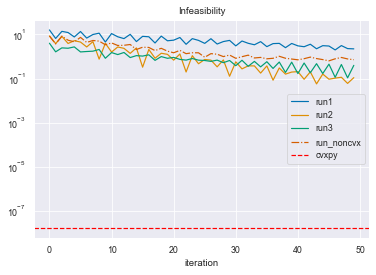

In [15]:
r = np.linalg.norm(
    np.average(problem.estimates, axis=0) - y / 3
)
plt.plot(run1['residuals'], label='run1')
plt.plot(run2['residuals'], label='run2')
plt.plot(run3['residuals'], label='run3')
plt.plot(run_noncvx['residuals'], label='run_noncvx', ls='-.')
plt.axhline(r, ls='--', color='red', label='cvxpy')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

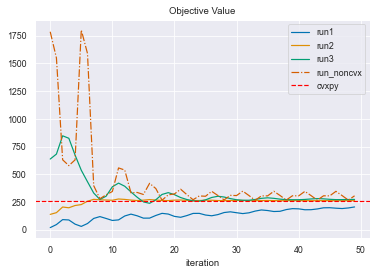

In [16]:
plt.plot(run1['obj_vals'], label='run1')
plt.plot(run2['obj_vals'], label='run2')
plt.plot(run3['obj_vals'], label='run3')
plt.plot(run_noncvx['obj_vals'], label='run_noncvx', ls='-.')
plt.axhline(problem.problem.objective.value, ls='--', color='red', label='cvxpy')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration');

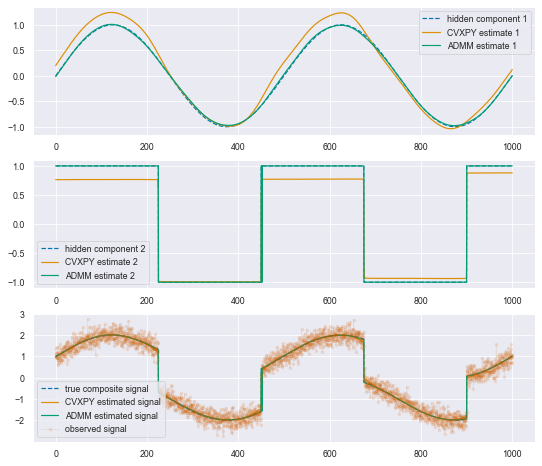

In [17]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run_noncvx['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run_noncvx['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run_noncvx['x2'] + run_noncvx['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()